<div style="text-align: center;">
  <a href="https://cognitiveclass.ai/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDL0321ENSkillsNetwork951-2022-01-01">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DL0321EN-SkillsNetwork/image/IDSN-logo.png" width="400">
  </a>
</div>


<h1 align=left><font size = 6>Lab: Comparative Analysis of Keras and PyTorch Models </font></h1>


<h5>Estimated time: 90 minutes</h5>


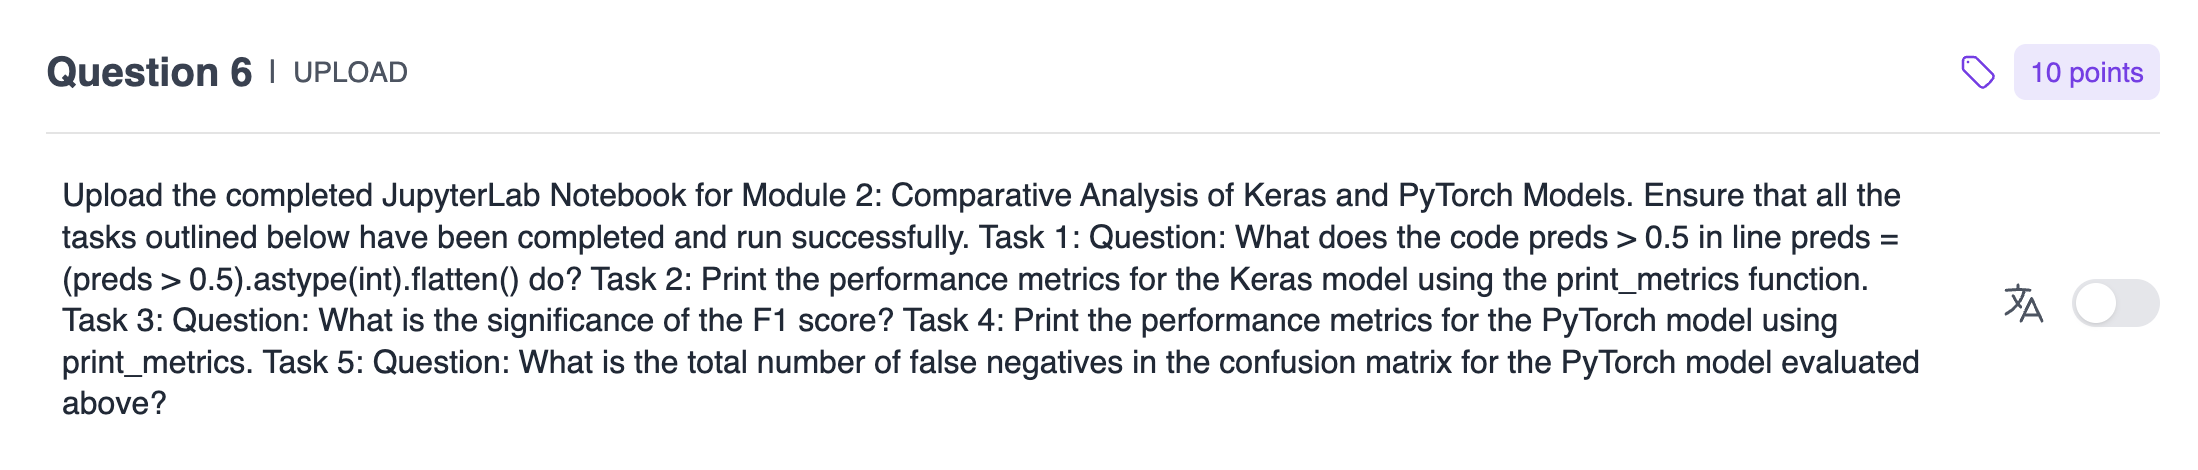

<h2>Objective</h2>

After completing this lab, you will be able to:
<ul>

1. Prepare data, load and evaluate Keras model.
2. Prepare data, load and evaluate PyTorch model.
3. Compute multiple performance metrics including accuracy, precision, recall, and f1-score.
4. Visualize receiver operating characteristic (ROC) curves.
</ul>


## Introduction

In this lab, you will compare the performance of the Keras-based and the PyTorch based convolutional neural network (CNN) models using various evaluation metrics.  Common metrics include:

- **Accuracy**: Measures how often the model is correct overall. A higher value means more total predictions are correct.

- **Precision**: Measures how many predicted positives are actually correct. A higher value means fewer false positives (incorrectly predicted positives).

- **Recall**: Measures how many real positives the model finds. A higher value means fewer false negatives (missed positive cases).

- **F1 Score**: Tells us about the balance between precision and recall. A higher value means a better trade-off between precision and recall.

- **ROC-AUC**: Measures the model’s ability to distinguish classes. A higher value reflects a model that can better distinguish between classes at all probability thresholds.


For all these metrics, the model should aim for values as close to 1.0 (or 100%) as possible. Lower values indicate poorer model performance. There are exceptions for some metrics in other settings (like various loss functions, where lower is better), but for these standard classification metrics, higher is always better.


## Table of Contents
<font size = 3>
    
1. [Data download and extraction](#Data-download-and-extraction)
2. [Package installation](#Package-installation)
3. [Library imports and setup](#Library-imports-and-setup)
4. [Evaluation metrics](#Evaluation-metrics)
    1. [Accuracy](#1.-Accuracy)
    2. [Precision](#2.-Precision)
    3. [Recall](#3.-Recall-(sensitivity-or-true-positive-rate))
    4. [F1 score](#4.-F1-score)
    5. [Confusion matrix](#5.-Confusion-matrix)
    6. [ROC-AUC](#6.-ROC-AUC-(Receiver-operating-characteristic---Area-under-curve))
6. [Import the evaluation metrics](#Import-the-evaluation-metrics)
7. [Model paths and download](#Model-paths-and-download)
8. [Dataset path and parameters](#Dataset-path-and-parameters)
9. [PyTorch model evaluation and prediction](#PyTorch-model-evaluation-and-prediction)
10. [PyTorch metrics reporting](#PyTorch-metrics-reporting)
11. [Keras model evaluation and prediction](#Keras-model-evaluation-and-prediction)
12. [Keras metrics reporting](#Keras-metrics-reporting)
13. [ROC curve plotting](#ROC-curve-plotting)
14. [Comparing model performance](#Comparing-model-performance)

</font>


## Data download and extraction
We begin by downloading the dataset for evaluation of the models.
Here, you declare:
1. The dataset URL from where the dataset would be downloaded.
2. The dataset downloading primary function, based on `skillsnetwork` library.
3. The dataset fallback downloading function, based on regular `http` downloading functions.


In [ ]:
import os
import skillsnetwork

data_dir = "."
dataset_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/4Z1fwRR295-1O3PMQBH6Dg/images-dataSAT.tar"


def check_skillnetwork_extraction(extract_dir):
    """Check if the environment allows symlink creation for download/extraction."""
    symlink_test = os.path.join(extract_dir, "symlink_test")
    if not os.path.exists(symlink_test):
        os.symlink(os.path.join(os.sep, "tmp"), symlink_test)
        print("Write permissions available for downloading and extracting the dataset tar file")
        os.unlink(symlink_test)

async def download_tar_dataset(url, tar_path, extract_dir):
    """Download and extract dataset tar file asynchronously."""
    if not os.path.exists(tar_path):
        try:
            print(f"Downloading from {url}...")
            import httpx
            async with httpx.AsyncClient() as client:
                response = await client.get(url, follow_redirects=True)
                response.raise_for_status()
                with open(tar_path, "wb") as f:
                    f.write(response.content)
            print(f"Successfully downloaded '{tar_path}'.")
        except Exception as e:
            print(f"Download error: {e}")
    else:
        print(f"Dataset tar file already exists at: {tar_path}")
    import tarfile
    with tarfile.open(tar_path, 'r:*') as tar_ref:
        tar_ref.extractall(path=extract_dir)
        print(f"Successfully extracted to '{extract_dir}'.")

try:
    check_skillnetwork_extraction(data_dir)
    await skillsnetwork.prepare(url=dataset_url, path=data_dir, overwrite=True)
except Exception as e:
    print(e)
    print("Primary download/extraction method failed.")
    print("Falling back to manual download and extraction...")
    import tarfile
    import httpx
    from pathlib import Path
    file_name = Path(dataset_url).name
    tar_path = os.path.join(data_dir, file_name)
    await download_tar_dataset(dataset_url, tar_path, data_dir)

Write permissions available for downloading and extracting the dataset tar file


  0%|          | 0/6003 [00:00<?, ?it/s]

Saved to '.'


## Package installation

Install the required basic Python packages.


In [ ]:
%%time
%%capture captured_output
%pip install numpy==1.26
%pip install matplotlib==3.9.2
%pip install skillsnetwork

CPU times: user 6.76 s, sys: 904 ms, total: 7.66 s
Wall time: 27.7 s


### Install PyTorch library


In [ ]:
%%time
%pip install torch==2.7.0 torchvision==0.22

CPU times: user 3.03 s, sys: 365 ms, total: 3.4 s
Wall time: 10.4 s


### Install PyTorch helper libraries


### Install tensorflow library for Keras


In [ ]:
%%time
%pip install tensorflow==2.19

CPU times: user 3.03 s, sys: 397 ms, total: 3.43 s
Wall time: 11.1 s


### Install SkLearn library for evaluation metrics


In [ ]:
%%time
%pip install scikit-learn==1.7.0

CPU times: user 3.02 s, sys: 397 ms, total: 3.41 s
Wall time: 9.18 s


## Library imports and setup

Import essential libraries for data manipulation, visualization, and suppresses warnings for cleaner notebook output.


In [ ]:
%%time
import warnings
warnings.filterwarnings('ignore')

import os
import time
import httpx
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

CPU times: user 136 ms, sys: 18.6 ms, total: 154 ms
Wall time: 361 ms


### PyTorch library imports

Import core PyTorch modules for model building, optimization, data loading, and functional utilities.


In [ ]:
%%time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F

print("Imported libraries")

Imported libraries
CPU times: user 5.73 s, sys: 799 ms, total: 6.53 s
Wall time: 10 s


### TensorFlow/Keras library imports

These imports set the environment variables to reduce TensorFlow logging noise and imports Keras modules for model building and training. They detect GPU availability for device assignment.


In [ ]:
%%time
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import HeUniform
from tensorflow.keras.callbacks import ModelCheckpoint

gpu_list = tf.config.list_physical_devices('GPU')
device = "gpu" if gpu_list != [] else "cpu"
print(f"Device available for training: {device}")

Device available for training: cpu
CPU times: user 6.44 s, sys: 1.26 s, total: 7.7 s
Wall time: 15.4 s


## Evaluation metrics

The following metrics are used for evaluation of various AI/ML models:
    
- Accuracy
- Precision
- Recall
- F1 score
- Confusion matrix
- Receiver Operating Characteristic - Area Under Curve (ROC-AUC)

You can read about their calculation methods and their significance for model performance below.


### 1. Accuracy

**Definition:**
Accuracy is the proportion of correct predictions (both true positives and true negatives) among the total number of cases examined. In other words, it measures how often the classifier is correct overall.

**Formula:**
\[
Accuracy = $\frac{TP + TN}{TP + TN + FP + FN}$
\]

- TP: True positives (correctly predicted positive cases)
- TN: True negatives (correctly predicted negative cases)
- FP: False positives (incorrectly predicted positive cases)
- FN: False negatives (incorrectly predicted negative cases)

**Significance:**

Accuracy is intuitive and easy to interpret, making it a common first metric for model evaluation. However, it can be misleading if the dataset is imbalanced (i.e., one class is much more frequent than the other). This is because a model can achieve high accuracy by simply predicting the majority class.


### 2. Precision

**Definition:**
Precision measures the proportion of positive predictions that are actually correct. It answers the question: "Of all the samples that the model predicted as positive, how many were truly positive?"

**Formula:**
\[
Precision = $\frac{TP}{TP + FP}$
\]

**Significance:**
Precision is crucial when the cost of a false positive is high. For example, in medical diagnosis, predicting a disease when it's not present (false positive) can lead to unnecessary treatments. In land classification, high precision means that when the model predicts a tile as agricultural, it is likely correct.


### 3. Recall (sensitivity or true positive rate)

**Definition:**
Recall measures the proportion of actual positive cases that were correctly identified by the model. It answers: "Of all the true positive samples, how many did the model identify?"

**Formula:**
\[
Recall = $\frac{TP}{TP + FN}$
\]

**Significance:**
Recall is important when the cost of missing a positive case (false negative) is high. In land classification, high recall means the model is good at finding all the agricultural land, even if it sometimes mislabels non-agricultural land as agricultural.


### 4. F1 score

**Definition:**
The F1 score is the harmonic mean of precision and recall. It provides a single metric that balances both concerns. It is especially useful when you need to find an equilibrium between precision and recall.

**Formula:**
\[
F1 = $2 \times \frac{Precision \times Recall}{Precision + Recall}$
\]

**Significance:**
The F1 score is especially valuable when the class distribution is uneven or when both false positives and false negatives are important. It penalizes extreme values, so a model with high precision but low recall (or vice versa) will have a lower F1 score.


### 5. Confusion matrix

**Definition:**
A confusion matrix is a table that summarizes the performance of a classification algorithm. It displays the counts of true positives, false positives, true negatives, and false negatives.

|               | Predicted positive | Predicted negative |
|---------------|-------------------|-------------------|
| Actual positive | True positive (TP) | False negative (FN) |
| Actual negative | False positive (FP) | True negative (TN) |

**Significance:**
The confusion matrix provides a detailed breakdown of model errors and successes, helping you understand not just how often the model is right, but *how* it is wrong. This is crucial for diagnosing issues like class imbalance or systematic misclassification.


### 6. ROC-AUC (Receiver operating characteristic - Area under curve)

**Definition:**
ROC-AUC measures the model's ability to distinguish between classes across all possible classification thresholds. The ROC curve plots the true positive rate (recall) against the false positive rate at various thresholds. The AUC (area under the curve) summarizes this performance in a single value between 0 and 1.

**Significance:**
A model with an ROC-AUC of 1.0 perfectly distinguishes between classes, while a value of 0.5 suggests random guessing. ROC-AUC is especially useful for imbalanced datasets and when you care about the ranking of predictions rather than their absolute values.


## Import the evaluation metrics

Here you define the functions to compute and print classification metrics including accuracy, precision, recall, F1 score, ROC-AUC, confusion matrix, and log loss. These functions support both Keras and PyTorch model outputs.


In [ ]:
%%time
from sklearn.metrics import (accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score,
                             roc_curve,
                             roc_auc_score,
                             log_loss,
                             classification_report,
                             confusion_matrix,
                             ConfusionMatrixDisplay,
                            )
from sklearn.preprocessing import label_binarize

# define a function to get the metrics comprehensively
def model_metrics(y_true, y_pred, y_prob, class_labels):
    metrics = {'Accuracy': accuracy_score(y_true, y_pred),
               'Precision': precision_score(y_true, y_pred),
               'Recall': recall_score(y_true, y_pred),
               'Loss': log_loss(y_true, y_prob),
               'F1 Score': f1_score(y_true, y_pred),
               'ROC-AUC': roc_auc_score(y_true, y_prob),
               'Confusion Matrix': confusion_matrix(y_true, y_pred),
               'Classification Report': classification_report(y_true, y_pred, target_names=class_labels, digits=4),
               "Class labels": class_labels
              }
    return metrics

#function to print the metrics
def print_metrics(y_true, y_pred, y_prob, class_labels, model_name):
    metrics = model_metrics(y_true, y_pred, y_prob, class_labels)
    print(f"Evaluation metrics for the \033[1m{model_name}\033[0m")
    print(f"Accuracy: {'':<1}{metrics["Accuracy"]:.4f}")
    print(f"ROC-AUC: {'':<2}{metrics["ROC-AUC"]:.4f}")
    print(f"Loss: {'':<5}{metrics["Loss"]:.4f}\n")
    print(f"Classification report:\n\n  {metrics["Classification Report"]}")
    print("========= Confusion Matrix =========")
    disp = ConfusionMatrixDisplay(confusion_matrix=metrics["Confusion Matrix"],
                                  display_labels=metrics["Class labels"])

    disp.plot()
    plt.show()



CPU times: user 38.6 ms, sys: 8.92 ms, total: 47.5 ms
Wall time: 47.7 ms


## Model download helper

Now, define an asynchronous function to download model files from given URLs, if they are not already present locally.
You use `httpx` for asynchronous HTTP requests with error handling.


In [ ]:
async def download_model(url, model_path):
    if not os.path.exists(model_path):
        try:
            print(f"Downloading from {url}...")
            import httpx
            async with httpx.AsyncClient() as client:
                response = await client.get(url, follow_redirects=True)
                response.raise_for_status()
                with open(model_path, "wb") as f:
                    f.write(response.content)
            print(f"Successfully downloaded '{model_path}'.")
        except Exception as e:
            print(f"Download error: {e}")
    else:
        print(f"Model file already downloaded at: {model_path}")

## Model paths and download

In the cell below, you define the file paths and URLs for the Keras and PyTorch models and download them using the `download_model` function defined above.


In [ ]:
data_dir = "."

keras_model_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/U-uPeyCyOQYh0GrZPGsqoQ/ai-capstone-keras-best-model-model.keras"
keras_model_name = "ai-capstone-keras-best-model-model_downloaded.keras"
keras_model_path = os.path.join(data_dir, keras_model_name)

pytorch_state_dict_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/8J2QEyQqD8x9zjrlnv6N7g/ai-capstone-pytorch-best-model-20250713.pth"
pytorch_state_dict_name = "ai_capstone_pytorch_best_model_state_dict_downloaded.pth"
pytorch_state_dict_path = os.path.join(data_dir, pytorch_state_dict_name)

await download_model(keras_model_url, keras_model_path)
await download_model(pytorch_state_dict_url, pytorch_state_dict_path)

Successfully downloaded './ai-capstone-keras-best-model-model_downloaded.keras'.
Successfully downloaded './ai_capstone_pytorch_best_model_state_dict_downloaded.pth'.


## Dataset path and parameters

Here, for downstream processing, you define
1. the dataset directory path
2. define image dimensions
3. number of channels
4. batch size
5. number of classes
6. class labels


In [ ]:
dataset_path = os.path.join(data_dir, "images_dataSAT")
print(dataset_path)

img_w, img_h = 64, 64
n_channels = 3
batch_size = 128
num_classes = 2

agri_class_labels = ["non-agri", "agri"]


./images_dataSAT


## Keras model evaluation and prediction

In this cell, you will:
- Use `ImageDataGenerator` to rescale images.
- Load test images from the dataset directory.
- Load the saved Keras model using `tf.keras.models.load_model`.
- Run predictions on the test set, collect predicted probabilities, predicted classes, and true labels.


In [ ]:
%%time

datagen = ImageDataGenerator(rescale=1./255)
prediction_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_w, img_h),
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False
)

keras_model = tf.keras.models.load_model(keras_model_path)

steps = int(np.ceil(prediction_generator.samples / prediction_generator.batch_size))
batch_size = int(prediction_generator.batch_size)
print(f"Number of Steps: {steps} with batch size: {batch_size}")

all_preds_keras = []
all_probs_keras = []
all_labels_keras = []

for step_idx, step in enumerate(tqdm(range(steps), desc="Steps")):
    images, labels = next(prediction_generator)
    preds = keras_model.predict(images, verbose='0')
    all_probs_keras.extend(preds)
    preds = (preds > 0.5).astype(int).flatten()
    all_preds_keras.extend(preds)
    all_labels_keras.extend(labels)

Found 6000 images belonging to 2 classes.
Number of Steps: 47 with batch size: 128


Steps: 100%|██████████| 47/47 [01:14<00:00,  1.58s/it]

CPU times: user 1min 53s, sys: 1.9 s, total: 1min 54s
Wall time: 1min 17s


#### Question: What does the code **`preds > 0.5`** in line `preds = (preds > 0.5).astype(int).flatten()` do?


Please use the space below to write your answer.


It converts all predictions greater than 0.5 to True or assign to class 1. Rest of the predictions are False, assigned to class 0

## Keras metrics reporting


### Task 1: Print the performance metrics for the Keras model using `print_metrics` function

Print various performance metrics for the **Keras** model. You may use the previously defined metrics print function `print_metrics`.


Evaluation metrics for the Keras Model
Accuracy:  0.9925
ROC-AUC:   1.0000
Loss:      0.0247

Classification report:

                precision    recall  f1-score   support

    non-agri     0.9852    1.0000    0.9926      3000
        agri     1.0000    0.9850    0.9924      3000

    accuracy                         0.9925      6000
   macro avg     0.9926    0.9925    0.9925      6000
weighted avg     0.9926    0.9925    0.9925      6000

========= Confusion Matrix =========


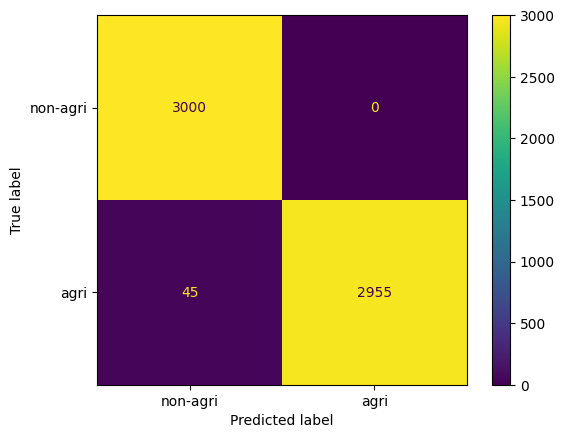

In [ ]:
## Please use the space below to write your answer
print_metrics(y_true = all_labels_keras,
              y_pred = all_preds_keras,
              y_prob = all_probs_keras,
              class_labels = agri_class_labels,
              model_name = "Keras Model"
             )


#### Question: What is the significance of `f1 score`?


Please use the space below to write your answer.


It is useful when both false positives and false negatives are importan

## PyTorch model evaluation and prediction

In this cell, you:
- Set device for inference (GPU if available).
- Define data transformations including resizing, normalization.
- Load the dataset using `ImageFolder` and prepares a DataLoader.
- Define the CNN architecture matching the saved state dict.
- Load model weights.
- Run inference on the test set, collecting predicted classes, probabilities, and true labels for metric calculation.


In [ ]:
%%time
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Processing inference on {device}")

train_transform = transforms.Compose([
    transforms.Resize((img_w, img_h)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
full_dataset = datasets.ImageFolder(dataset_path, transform=train_transform)
test_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=False)

model = nn.Sequential(
    nn.Conv2d(3, 32, 5, padding=2), nn.ReLU(),
    nn.MaxPool2d(2), nn.BatchNorm2d(32),
    nn.Conv2d(32, 64, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(64),
    nn.Conv2d(64, 128, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(128),
    nn.Conv2d(128, 256, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(256),
    nn.Conv2d(256, 512, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(512),
    nn.Conv2d(512, 1024, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(1024),
    nn.AdaptiveAvgPool2d(1), nn.Flatten(),
    nn.Linear(1024, 2048), nn.ReLU(), nn.BatchNorm1d(2048), nn.Dropout(0.4),
    nn.Linear(2048, num_classes)
).to(device)

print("Created model, now loading the weights from saved model state dict")
model.load_state_dict(torch.load(pytorch_state_dict_path))
print("Loaded model state dict, now getting predictions")

all_preds_pytorch = []
all_labels_pytorch = []
all_probs_pytorch = []


model.eval()
with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(tqdm(test_loader, desc="Step")):
#    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        probs = F.softmax(outputs, dim=1)[:, 1]  # probability for class 1
        all_probs_pytorch.extend(probs.cpu())
        all_preds_pytorch.extend(preds.cpu().numpy().flatten())
        all_labels_pytorch.extend(labels.numpy())

Processing inference on cpu
Created model, now loading the weights from saved model state dict
Loaded model state dict, now getting predictions


Step: 100%|██████████| 47/47 [01:25<00:00,  1.81s/it]

CPU times: user 1min 11s, sys: 10.8 s, total: 1min 21s
Wall time: 1min 25s


## PyTorch metrics reporting


### Task 2: Print the performance metrics for the PyTorch model using `print_metrics`

Print various performance metrics for the PyTorch model. You may use the previously defined metrics print function `print_metrics`.


Evaluation metrics for the PyTorch Model
Accuracy:  0.9988
ROC-AUC:   1.0000
Loss:      0.0024

Classification report:

                precision    recall  f1-score   support

    non-agri     0.9993    0.9983    0.9988      3000
        agri     0.9983    0.9993    0.9988      3000

    accuracy                         0.9988      6000
   macro avg     0.9988    0.9988    0.9988      6000
weighted avg     0.9988    0.9988    0.9988      6000

========= Confusion Matrix =========


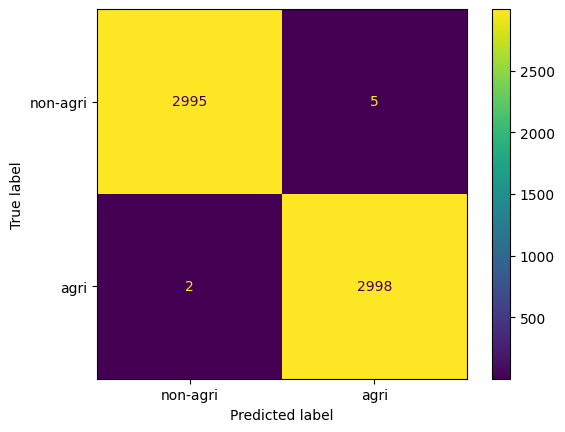

In [ ]:
## Please use the space below to write your answer

print_metrics(y_true = all_labels_pytorch,
              y_pred = all_preds_pytorch,
              y_prob = all_probs_pytorch,
              class_labels = agri_class_labels,
              model_name = "PyTorch Model"
             )

#### Question: What are the total number of false negatives in the `confusion matrix` in the PyTorch model evaluated above?


Please use the space below to write your answer.


Total Flase negatives are 5

## ROC curve plotting

First, define a function to plot ROC curves for binary or multi-class classification using scikit-learn's `roc_curve` and `roc_auc_score`. It handles both single-class and multi-class cases by binarizing labels if needed.

Next, plot the ROC curves for both the models.


In [ ]:

def plot_roc(y_true, y_prob, model_name):
    n_classes = y_prob.shape[1] if y_prob.ndim > 1 else 1
    if n_classes == 1:
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        auc = roc_auc_score(y_true, y_prob)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.2f})')
    else:
        y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
            auc = roc_auc_score(y_true_bin[:, i], y_prob[:, i])
            plt.plot(fpr, tpr, label=f'{model_name} class {i} (AUC = {auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()

### ROC curve plotting for both models

Plot the ROC curves for both Keras and PyTorch models on the same figure for visual performance comparison.


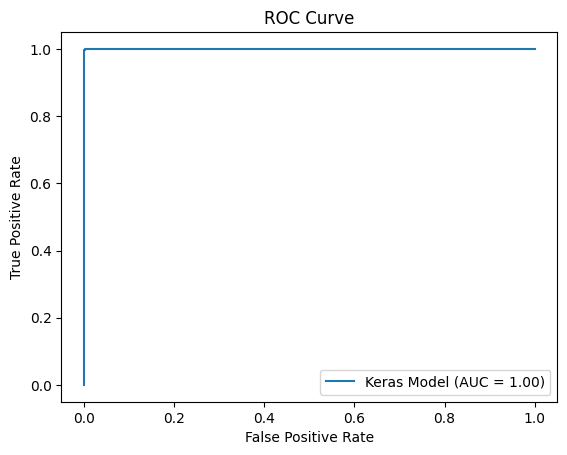

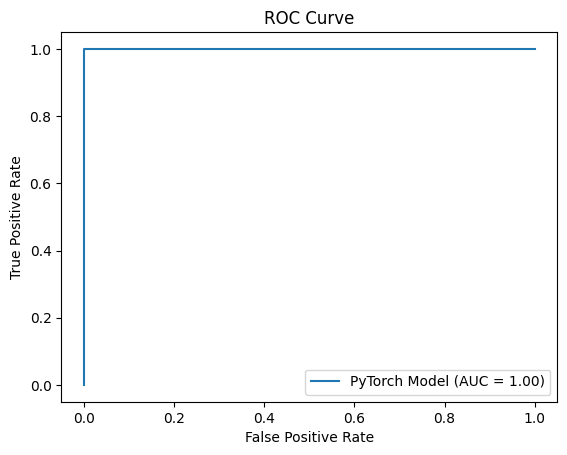

In [ ]:
plot_roc(np.array(all_labels_keras), np.array(all_probs_keras), "Keras Model")
plt.show()
plot_roc(np.array(all_labels_pytorch), np.array(all_probs_pytorch), "PyTorch Model")
plt.show()

## Comparing model performance

Now compare the performance of different models to understand which model would be the best performer for your land classification task.


In [ ]:
# get the Keras model performance metrics
metrics_keras = model_metrics(all_labels_keras, all_preds_keras, all_probs_keras, agri_class_labels)

# get the PyTorch model performance metrics
metrics_pytorch = model_metrics(all_labels_pytorch, all_preds_pytorch, all_probs_pytorch, agri_class_labels)


# Display the comparison of metrics
print("{:<18} {:<15} {:<15}".format('\033[1m'+ 'Metric' + '\033[0m',
                                    'Keras Model',
                                    'PyTorch Model'))

mertics_list = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC']

for k in mertics_list:
    print("{:<18} {:<15.4f} {:<15.4f}".format('\033[1m'+k+'\033[0m',
                                              metrics_keras[k],
                                              metrics_pytorch[k]))

Metric     Keras Model     PyTorch Model  
Accuracy   0.9925          0.9988         
Precision  1.0000          0.9983         
Recall     0.9850          0.9993         
F1 Score   0.9924          0.9988         
ROC-AUC    1.0000          1.0000         


### Metric analysis

The metrics for the pre-trained Keras and PyTorch models for evaluating the provided dataset are:

- **Accuracy**
    1. Keras: 0.9925
    2. PyTorch: 0.9988
    
    ===> Both models achieve exceptional accuracy, but the **PyTorch model makes fewer mistakes**.

- **Precision**
    1. Keras: 1.0000
    2. PyTorch: 0.9983

    ===> The **Keras** model perfectly **avoids false positives**, whereas the PyTorch model is slightly less perfect but still excellent.

- **Recall**
    1. Keras: 0.9850
    2. PyTorch: 0.9993
    
    ===> The **PyTorch** model is marginally better at **identifying all true positives**, capturing nearly all actual positive cases, while the Keras model misses a few.

- **F1 Score**
    1. PyTorch: 0.9988
    2. Keras: 0.9924
    
    ===> The F1 score, which balances precision and recall, favors the **PyTorch** model thanks to its **stronger recall**.

- **ROC-AUC**
    1. Keras: 1.0000
    2. PyTorch: 1.0000
    
    ===> Both models reach maximum possible **discrimination between classes**, indicating outstanding capability for binary classification.


### **Model comparison: Key insights**


**PyTorch model strengths**

 - Achieves the highest scores in accuracy, recall, and F1, indicating extremely robust overall performance and near-perfect classification of positive cases
- ROC-AUC of 1.0 shows perfect class separability


**Keras model strengths**

- Displays almost perfect precision every positive prediction made is correct
- Also achieves perfect ROC-AUC, indicating outstanding discrimination ability


**Common strength**

- Both models deliver flawless ROC-AUC, suggesting both are highly effective for this classification task


**Recommendations**

Based on the scores from the uploaded pre-trained models:

- The PyTorch model is preferable for applications where missing any positive instances is costly (higher recall)
- The Keras model is optimal for scenarios where making any false positive error is unacceptable (higher precision).


**Next**

- Analyze the confusion matrices to investigate the errors.
- Monitor real-world performance, as even marginal differences can become important in high-impact applications.


**Summary**

Both models excel in all evaluated metrics and would be highly reliable in production. The PyTorch model demonstrates a modest edge in recall and F1 score, while the Keras model maximizes precision. The choice between models should ultimately reflect the specific requirements and risk tolerance of your use case.



## Save and download the notebook for **final project** submission and evaluation

You will need to save and download the completed notebook for final project submission and evaluation.
<br>For saving and downloading the completed notebook, please follow the steps given below:</br>

<font size = 4>  

1) **Complete** all the tasks and questions given in the notebook.

<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/nv4jHlPU5_R1q7ZJrZ69eg/DL0321EN-M1L1-Save-IPYNB-Screenshot-1.png" style="width:600px; border:0px solid black;">

2) **Save** the notebook.</style>
<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/9-WPWD4mW1d-RV5Il5otTg/DL0321EN-M1L1-Save-IPYNB-Screenshot-2.png" style="width:600px; border:0px solid black;">

3) Identify and right click on the **correct notebook file** in the left pane.</style>
<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/RUSRPw7NT6Sof94B7-9naQ/DL0321EN-M1L1-Save-IPYNB-Screenshot-3.png" style="width:600px; border:0px solid black;">

4) Click on **Download**.</style>
<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/HHry4GT-vhLEcRi1T_LHGg/DL0321EN-M1L1-Save-IPYNB-Screenshot-4.png" style="width:600px; border:0px solid black;">

5) Download and **Save** the Jupyter notebook file on your computer **for final submission**.</style>
<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/hhsJbxc6R-T8_pXQGjMjvg/DL0321EN-M1L1-Save-IPYNB-Screenshot-5.png" style="width:600px; border:0px solid black;">
  </font>


## Conclusion

Congratulations! You've successfully evaluated and compared two deep learning models, one using Keras and the other using the PyTorch framework.

You learnt about a comprehensive workflow for comparing Keras and PyTorch models on the same dataset and got hands-on experience on:
- data preparation
- model loading
- predicting dataset
- metric computation
- ROC visualization
- Model performance comparison

Using these framework independent metrics, you now know how to evaluate different models for their performance.


<h2>Author</h2>

[Saad Abdur Razzaq](https://www.linkedin.com/in/saadarazzaq)

Saad Abdur Razzaq is a Machine Learning Engineer at Effixly.



<!--
## Change Log

|  Date (YYYY-MM-DD) |  Version | Changed By  |  Change Description |
|---|---|---|---|
| 2025-07-14  | 1.0  | Aman  |  Created the lab |

-->


© Copyright IBM Corporation. All rights reserved.
